In [1]:
import os
import pandas as pd
import warnings
import sys
sys.path.insert(0, '..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Hindcast_Initialization, FigureDeveloper
import hydroeval as he
import sklearn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#Set working directories
cwd = os.getcwd() 
datapath = f"{os.path.expanduser('~')}/SWEML"
warnings.filterwarnings("ignore")

In [11]:
import importlib
importlib.reload(FigureDeveloper)

<module 'shared_scripts.FigureDeveloper' from '/home/jovyan/SWEML/Model/Neural_Network/../shared_scripts/FigureDeveloper.py'>

In [2]:
#Get datetime and corresponding background information to evaluate hindcast
#Need to load predictions2022-09-24.h5, 2019_predictions.h5 (if straight to here and did not make predictions)  

new_year = '2019'
threshold = '20.0'
Region_list = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','Greater_Yellowstone', 
     'N_Co_Rockies', 'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade',
     'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies', 
     'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast',
     'Greater_Glacier', 'Or_Coast'
              ]

Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']
model = 'Neural_Network'
frequency = 'Daily'

#if using daily, 345 locations from ASO not included in training data.
datelist = Hindcast_Initialization.Hindcast_Initialization(cwd, datapath, new_year, threshold, Region_list, frequency)
EvalDF = Hindcast_Initialization.HindCast_DataProcess(datelist,Region_list, cwd, datapath, model, frequency)

Creating files for a historical simulation within  'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low', 'Greater_Yellowstone', 'N_Co_Rockies', 'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade', 'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies', 'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast', 'Greater_Glacier', 'Or_Coast'  regions for water year  2019
New simulation start files complete
Getting prediction files
Site data processing complete, setting up prediction dataframes...
Finalizing Evaluation dataframes...
There were  345  sites missing from the prediction dataset occuring on  ['2019-03-24', '2019-04-28']


In [3]:
#Daily
FigureDeveloper.Peak_SWE(datelist, EvalDF, Region_list)

,ObsMax,PredMax,ObsMaxDate,PredMaxDate
Region,,,,
Northern Sierra Nevada,139.107333,132.49154,2019-04-02,2019-04-02
Southern Sierra Nevada High,133.996545,267.786181,2019-04-09,2019-04-02
Southern Sierra Nevada Low,100.838,71.080373,2019-03-26,2019-03-12
Greater Yellowstone,32.900471,42.603956,2019-04-16,2019-02-19
Upper Colorado Rockies,51.107474,67.171839,2019-04-16,2019-03-19
SW Montana,46.0756,54.051027,2019-04-16,2019-03-05
San Juan Mountains,55.372,67.191033,2019-04-02,2019-04-09
Great Basin,46.455263,56.814393,2019-03-26,2019-04-09
Northern Wasatch,61.896625,86.827858,2019-04-16,2019-04-23


In [185]:
#Weekly
FigureDeveloper.Peak_SWE(datelist, EvalDF, Region_list)

,ObsMax,PredMax,ObsMaxDate,PredMaxDate
Region,,,,
Northern Sierra Nevada,139.107333,141.081755,2019-04-02,2019-04-09
Southern Sierra Nevada High,133.996545,146.605839,2019-04-09,2019-04-02
Southern Sierra Nevada Low,100.838,67.059062,2019-03-26,2019-03-26
Greater Yellowstone,32.900471,31.704046,2019-04-16,2019-04-02
Upper Colorado Rockies,51.107474,52.685873,2019-04-16,2019-04-16
SW Montana,46.0756,47.342161,2019-04-16,2019-04-16
San Juan Mountains,55.372,70.143943,2019-04-02,2019-04-16
Great Basin,46.455263,49.150289,2019-03-26,2019-03-12
Northern Wasatch,61.896625,71.77316,2019-04-16,2019-04-16


In [4]:
#Daily
Model_Results = FigureDeveloper.Dict_2_DF(EvalDF, Region_list)
Model_Results.head()

,y_test,y_pred,Region,Date,Long,Lat,elevation_m,WYWeek,northness,VIIRS_SCA,hasSnow,y_pred_fSCA,error
00c4db22-a423-41a4-ada6-a8b1b04153a4,6.858,7.446571,Northern Sierra Nevada,2018-12-11,-121.939413,41.166647,1661.50,10.0,-0.167901,55.500000,True,7.446571,-0.588571
018cf1a1-f945-4097-9c47-0c4690538bb5,17.780,12.036483,Northern Sierra Nevada,2018-12-11,-120.618890,39.675880,2057.50,10.0,-0.006909,55.500000,True,12.036483,5.743517
147d5eb4-e574-47e4-994a-8a2908c06050,11.176,10.679231,Northern Sierra Nevada,2018-12-11,-120.879401,39.786417,2013.00,10.0,0.011996,70.166667,True,10.679231,0.496769
6dd37e24-0a9c-4749-8ab6-7e26d42925d6,10.160,8.366630,Northern Sierra Nevada,2018-12-11,-121.786700,40.780052,1787.00,10.0,-0.191108,56.500000,True,8.366630,1.793370
76b55900-eb3d-4d25-a538-f74302ffe72d,15.494,17.881886,Northern Sierra Nevada,2018-12-11,-120.178716,41.993149,2261.25,10.0,0.039906,100.000000,True,17.881886,-2.387886


In [186]:
#Weekly
Model_Results = FigureDeveloper.Dict_2_DF(EvalDF, Region_list)
Model_Results.head()

,y_test,y_pred,Region,Date,y_test_prev,prev_SWE,Long,Lat,elevation_m,WYWeek,northness,VIIRS_SCA,hasSnow,prev_SWE_error,y_pred_fSCA,error
00c4db22-a423-41a4-ada6-a8b1b04153a4,6.858,6.345891,Northern Sierra Nevada,2018-12-11,0.0,3.126142,-121.939413,41.166647,1661.50,10.0,-0.167901,55.500000,True,-1.230765,6.345891,0.512109
018cf1a1-f945-4097-9c47-0c4690538bb5,17.780,11.836120,Northern Sierra Nevada,2018-12-11,0.0,9.369790,-120.618890,39.675880,2057.50,10.0,-0.006909,55.500000,True,-3.688894,11.836120,5.943880
147d5eb4-e574-47e4-994a-8a2908c06050,11.176,10.136005,Northern Sierra Nevada,2018-12-11,0.0,7.414898,-120.879401,39.786417,2013.00,10.0,0.011996,70.166667,True,-2.919251,10.136005,1.039995
6dd37e24-0a9c-4749-8ab6-7e26d42925d6,10.160,7.324366,Northern Sierra Nevada,2018-12-11,0.0,4.214518,-121.786700,40.780052,1787.00,10.0,-0.191108,56.500000,True,-1.659259,7.324366,2.835634
76b55900-eb3d-4d25-a538-f74302ffe72d,15.494,17.716959,Northern Sierra Nevada,2018-12-11,0.0,13.316327,-120.178716,41.993149,2261.25,10.0,0.039906,100.000000,True,-5.242649,17.716959,-2.222959


# Daily

In [5]:
#put all regions together for basic metrics
allregions = pd.DataFrame()
for region in EvalDF.keys():
    allregions = pd.concat([allregions, EvalDF[region]])
    
y_pred = allregions['y_pred_fSCA']
y_test = allregions['y_test']
    
kge, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
pbias = he.evaluator(he.pbias, y_pred, y_test)


print('There are ', len(allregions), ' hindcast evaluation obs')
print('All regions KGE is: ', kge[0])
print('All regions rmse is: ', rmse)
print('All regions pbias is: ', pbias[0])

There are  6322  hindcast evaluation obs
All regions KGE is:  0.47292149784675264
All regions rmse is:  29.699162098320198
All regions pbias is:  -12.420045889810384


# Weekly

In [187]:
#put all regions together for basic metrics
allregions = pd.DataFrame()
for region in EvalDF.keys():
    allregions = pd.concat([allregions, EvalDF[region]])
    
y_pred = allregions['y_pred_fSCA']
y_test = allregions['y_test']
    
kge, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
pbias = he.evaluator(he.pbias, y_pred, y_test)


print('There are ', len(allregions), ' hindcast evaluation obs')
print('All regions KGE is: ', kge[0])
print('All regions rmse is: ', rmse)
print('All regions pbias is: ', pbias[0])


There are  6212  hindcast evaluation obs
All regions KGE is:  0.8318993092100895
All regions rmse is:  16.575552008670147
All regions pbias is:  5.696369570742343


In [6]:
#Daily
Maritime_Region, Prairie_Region, Alpine_Region, Snow_Class = FigureDeveloper.Sturm_Classified_Performance(Model_Results)

Maritime  RMSE:  50.89777150832451  R2:  -0.20627844530245576 pbias: [-21.48735052]
Alpine  RMSE:  18.5329711989451  R2:  0.3454429231557621 pbias: [-4.34002761]
Prairie  RMSE:  13.73781240361109  R2:  0.6061272999975778 pbias: [-10.19252115]


In [188]:
#Weekly
Maritime_Region, Prairie_Region, Alpine_Region, Snow_Class = FigureDeveloper.Sturm_Classified_Performance(Model_Results)

Maritime  RMSE:  26.199137770033982  R2:  0.6820441244066424 pbias: [17.498795]
Alpine  RMSE:  11.839739127995184  R2:  0.7328582984587237 pbias: [0.32024751]
Prairie  RMSE:  11.693965598756499  R2:  0.7146063270424805 pbias: [-4.90691345]


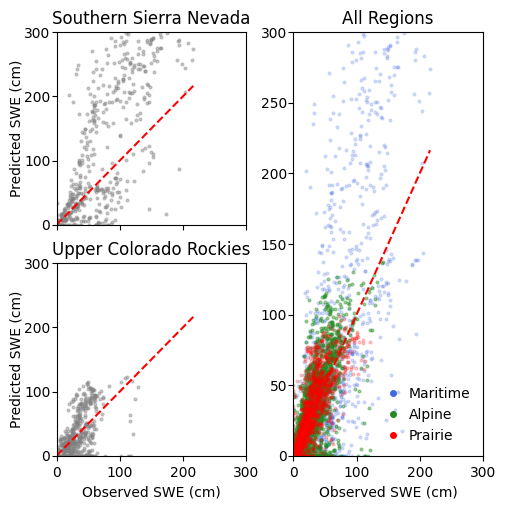

In [10]:
#Daily
FigureDeveloper.Slurm_Class_parity(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region, frequency)

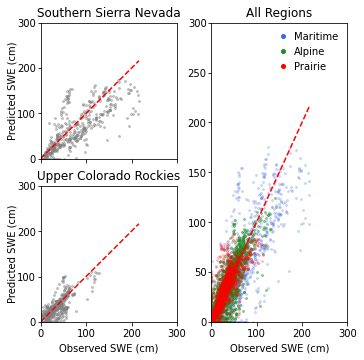

In [189]:
#weekly
FigureDeveloper.Slurm_Class_parity(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region)

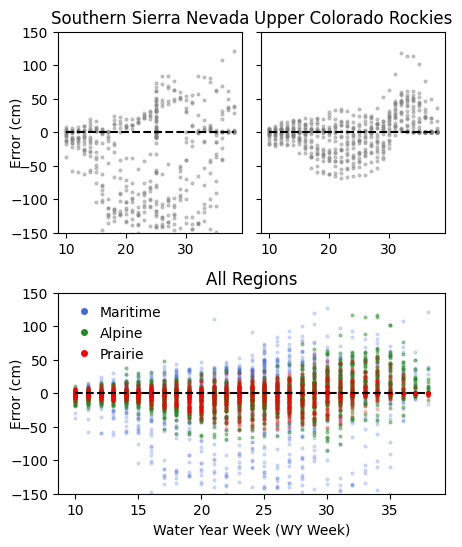

In [13]:
#Daily
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region, 'WYWeek', 'error', 'Water Year Week (WY Week)', 'Error (cm)', 'ErrorVsWYWeek', 2, frequency)

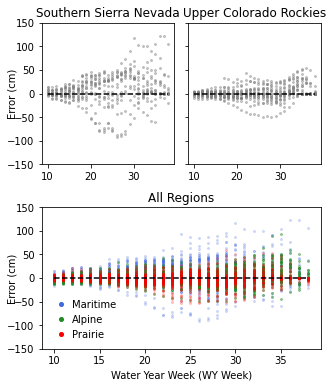

In [190]:
#Weekly
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region, 'WYWeek', 'error', 'Water Year Week (WY Week)', 'Error (cm)', 'ErrorVsWYWeek', 2)

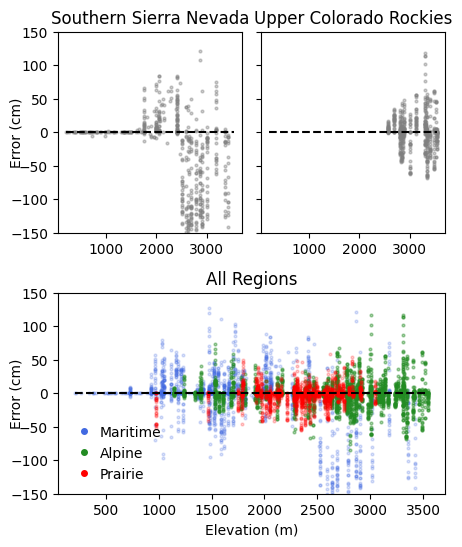

In [14]:
#Daily
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region,'elevation_m', 'error', 'Elevation (m)', 'Error (cm)', 'ErrorVsElevation', 2, frequency)

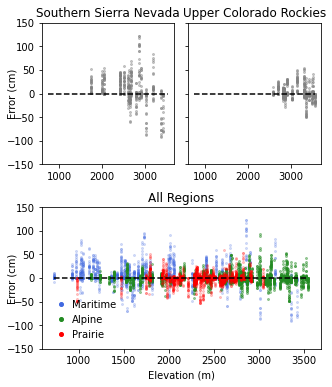

In [191]:
#Weekly
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region,'elevation_m', 'error', 'Elevation (m)', 'Error (cm)', 'ErrorVsElevation', 2)

['NW Rockies', 'Northern Colorado Rockies', 'Northern Wasatch', 'Upper Colorado Rockies']


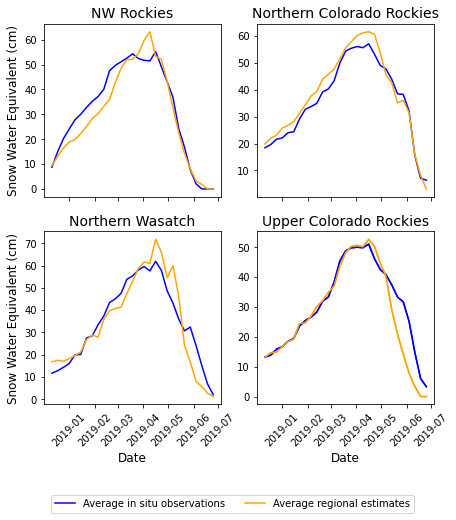

In [183]:
Regions = [ 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'N_Wasatch','N_Co_Rockies']
name = 'Alpine'
FigureDeveloper.SWE_TS_plot(datelist, EvalDF, Regions, name)

['Northern Sierra Nevada', 'Southern Sierra Nevada High', 'Southern Sierra Nevada Low', 'Southern Cascades', 'SW Montana', 'Great Basin', 'SW Utah', 'Sawtooth', 'NW Rockies', 'Northern Colorado Rockies', 'Northern Wasatch', 'Upper Colorado Rockies']


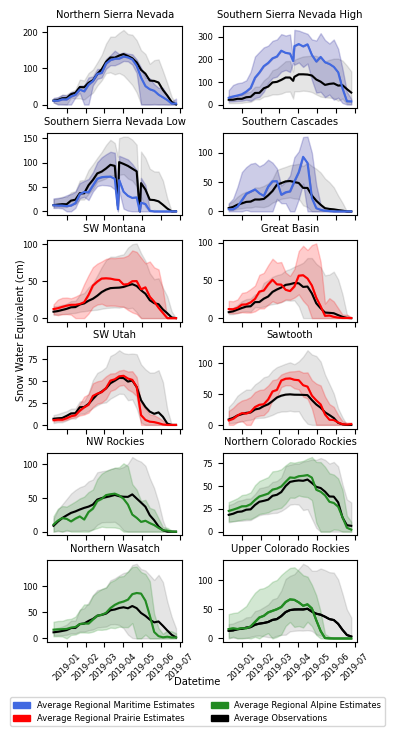

In [19]:
#Daily

importlib.reload(FigureDeveloper)

Maritime = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','S_Cascade']
Prarie = [ 'SW_Mont', 'GBasin', 'S_Wasatch','Sawtooth']
Alpine = [ 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'N_Wasatch','N_Co_Rockies']

plotname = 'All_Regions_TS'
RegionDict, RegionAll = FigureDeveloper.SWE_TS_plot_classes(datelist, EvalDF, Maritime, Prarie, Alpine, plotname, fontsize = 6, opacity=0.1, frequency = 'Daily')

['Northern Sierra Nevada', 'Southern Sierra Nevada High', 'Southern Sierra Nevada Low', 'Southern Cascades', 'SW Montana', 'Great Basin', 'SW Utah', 'Sawtooth', 'NW Rockies', 'Northern Colorado Rockies', 'Northern Wasatch', 'Upper Colorado Rockies']


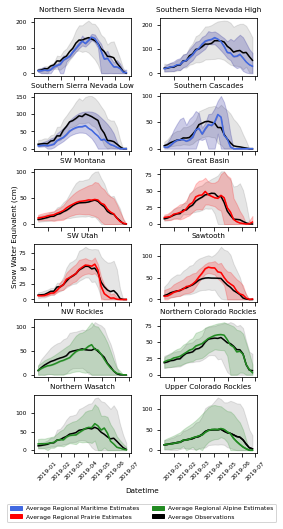

In [178]:
#Weekly

importlib.reload(FigureDeveloper)

Maritime = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','S_Cascade']
Prarie = [ 'SW_Mont', 'GBasin', 'S_Wasatch','Sawtooth']
Alpine = [ 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'N_Wasatch','N_Co_Rockies']

plotname = 'All_Regions_TS'
RegionDict, RegionAll = FigureDeveloper.SWE_TS_plot_classes(datelist, EvalDF, Maritime, Prarie, Alpine, plotname, fontsize = 6, opacity=0.1)


processing predictions into geodataframe


100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


creating figures for each prediction timestep


  0%|          | 0/1 [00:00<?, ?it/s]

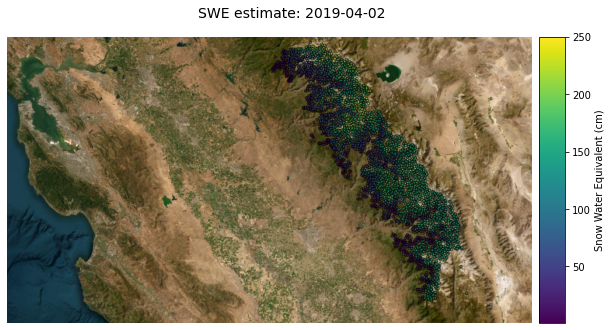

100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


In [18]:

Region_list = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low']
#Get list of optional tiles here: https://contextily.readthedocs.io/en/latest/providers_deepdive.html
variant = 'World_Imagery'#   'World_Physical_Map'
date = ["2019-04-02"]
FigureDeveloper.SSM_Fig(date, Region_list,variant)

In [300]:
#make snow class cdfs
Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']


In [139]:
MaritimeNSE = FigureDeveloper.slurmNSE(EvalDF, Maritime_Region)
PrarieeNSE = FigureDeveloper.slurmNSE(EvalDF, Prairie_Region)
AlpineNSE = FigureDeveloper.slurmNSE(EvalDF, Alpine_Region)

In [223]:
SNODAS = pd.read_pickle(r'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2018.pkl')

#remove lat/long
for region in SNODAS.keys():
    SNODAS[region].pop('Long')
    SNODAS[region].pop('Lat')
    

In [310]:
importlib.reload(FigureDeveloper)
#read in SNODAS pickle
SNODAS = pd.read_pickle(r'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2018.pkl')

#remove lat/long
for region in SNODAS.keys():
    SNODAS[region].pop('Long')
    SNODAS[region].pop('Lat')

SNODAS_MaritimeNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Maritime_Region)
SNODAS_PrarieNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Prairie_Region)
SNODAS_AlpineNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Alpine_Region)

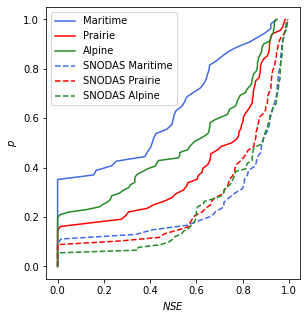

In [311]:
FigureDeveloper.regionCDF(MaritimeNSE, PrarieeNSE, AlpineNSE, SNODAS_MaritimeNSE, SNODAS_PrarieNSE, SNODAS_AlpineNSE, SNODAS=True, plt_save = True)